In [3]:
# EDA Libraries:

import pandas as pd
import numpy as np

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# LSTM:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import warnings


## Loading Dataset & Data Exploration (EDA)


In [4]:
dataset = pd.read_csv('data/sample_submission.csv')
df = dataset.copy()
df.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [5]:
df.describe

<bound method NDFrame.describe of           id  sales
0          0     52
1          1     52
2          2     52
3          3     52
4          4     52
...      ...    ...
44995  44995     52
44996  44996     52
44997  44997     52
44998  44998     52
44999  44999     52

[45000 rows x 2 columns]>

In [6]:
def load_data(file_name):
    """Returns a pandas dataframe from a csv file."""
    return pd.read_csv(file_name)

In [7]:
sales_data = load_data('data/train.csv')
df_s = sales_data.copy()
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
df_s.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [9]:
df_s['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

<AxesSubplot: >

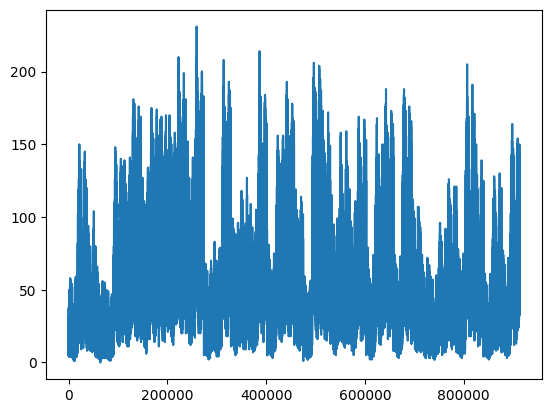

In [10]:
df_s['sales'].plot()

In [11]:
def monthlyORyears_sales(data,time=['monthly','years']):
    data = data.copy()
    if time == "monthly":
        # Drop the day indicator from the date column:
        data.date = data.date.apply(lambda x: str(x)[:-3])
    else:
        data.date = data.date.apply(lambda x: str(x)[:4])
        
   # Sum sales per month: 
    data = data.groupby('date')['sales'].sum().reset_index()
    data.date = pd.to_datetime(data.date)
        
    return data

In [12]:
m_df = monthlyORyears_sales(df_s,"monthly")

m_df.to_csv('./monthly_data.csv')

In [13]:
m_df.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


In [14]:
y_df = monthlyORyears_sales(df_s,"years")
y_df


,date,sales
0,2013-01-01,7941243
1,2014-01-01,9135482
2,2015-01-01,9536887
3,2016-01-01,10357160
4,2017-01-01,10733740


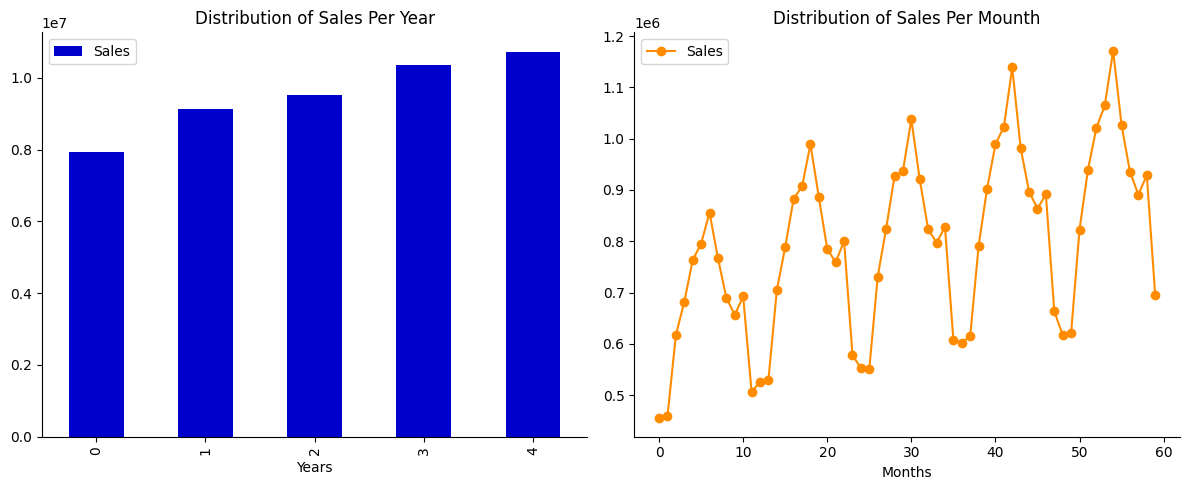

In [15]:
layout = (1, 2)

raw = plt.subplot2grid(layout, (0 ,0))
law = plt.subplot2grid(layout, (0 ,1))

years = y_df['sales'].plot(kind = "bar",color = 'mediumblue', label="Sales",ax=raw, figsize=(12,5))
months = m_df['sales'].plot(marker = 'o',color = 'darkorange', label="Sales", ax=law)

years.set(xlabel = "Years",title = "Distribution of Sales Per Year")
months.set(xlabel = "Months", title = "Distribution of Sales Per Mounth")

sns.despine()
plt.tight_layout()

years.legend()
months.legend()


## Data Exploration (EDA)


In [16]:
def sales_time(data):
    """Time interval of dataset:"""

    data.date = pd.to_datetime(data.date)
    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print(f"Days: {n_of_days.days}\nYears: {n_of_years}\nMonth: {12 * n_of_years}")

In [17]:
sales_time(df_s)

Days: 1825
Years: 5
Month: 60


### Sales Data Per Store

In [18]:
# Let's sell it per store:

def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=sales_by_store.store, y=sales_by_store.sales, color='darkred')
    
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    
    return sales_by_store

,store,sales
0,1,4315603
1,2,6120128
2,3,5435144
3,4,5012639
4,5,3631016
5,6,3627670
6,7,3320009
7,8,5856169
8,9,5025976
9,10,5360158


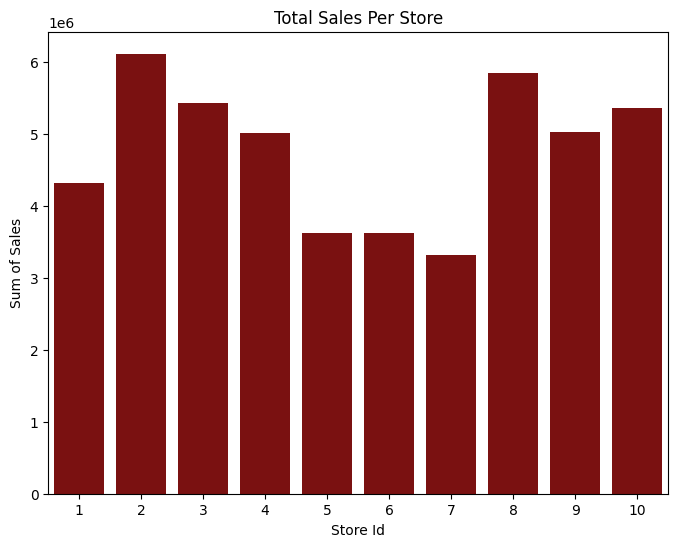

In [19]:
sales_per_store(df_s)

### Mean Monthly Sales

In [20]:
# Overall for 5 years:

average_m_sales = m_df.sales.mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

def avarage_12months():
# Last 1 years (this will be the forecasted sales):
    average_m_sales_1y = m_df.sales[-12:].mean()
    print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")
avarage_12months()

Overall Avarage Monthly Sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


### Determining Time Series Stationary

In [21]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(x=x_col, y=y_col, data = data, ax = ax, color = 'darkblue', label='Total Sales')
    
    s_mean = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date, format='%Y')
    sns.lineplot(x=(s_mean.date + datetime.timedelta(6*365/12)), y=y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Years",
           ylabel = "Sales",
           title = title)

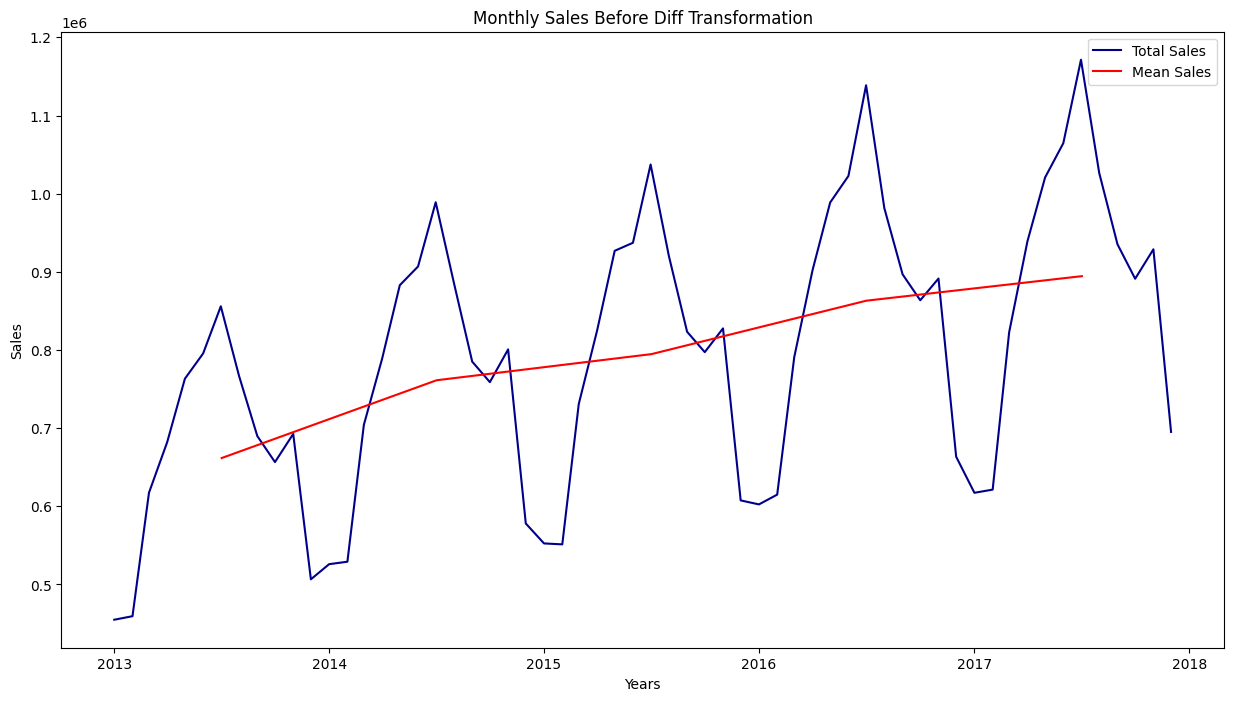

In [22]:
time_plot(m_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation' )

### Differencing

In [23]:
def get_diff(data):
    """Calculate the difference in sales month over month:"""
    
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('./stationary_df.csv')
    
    return data

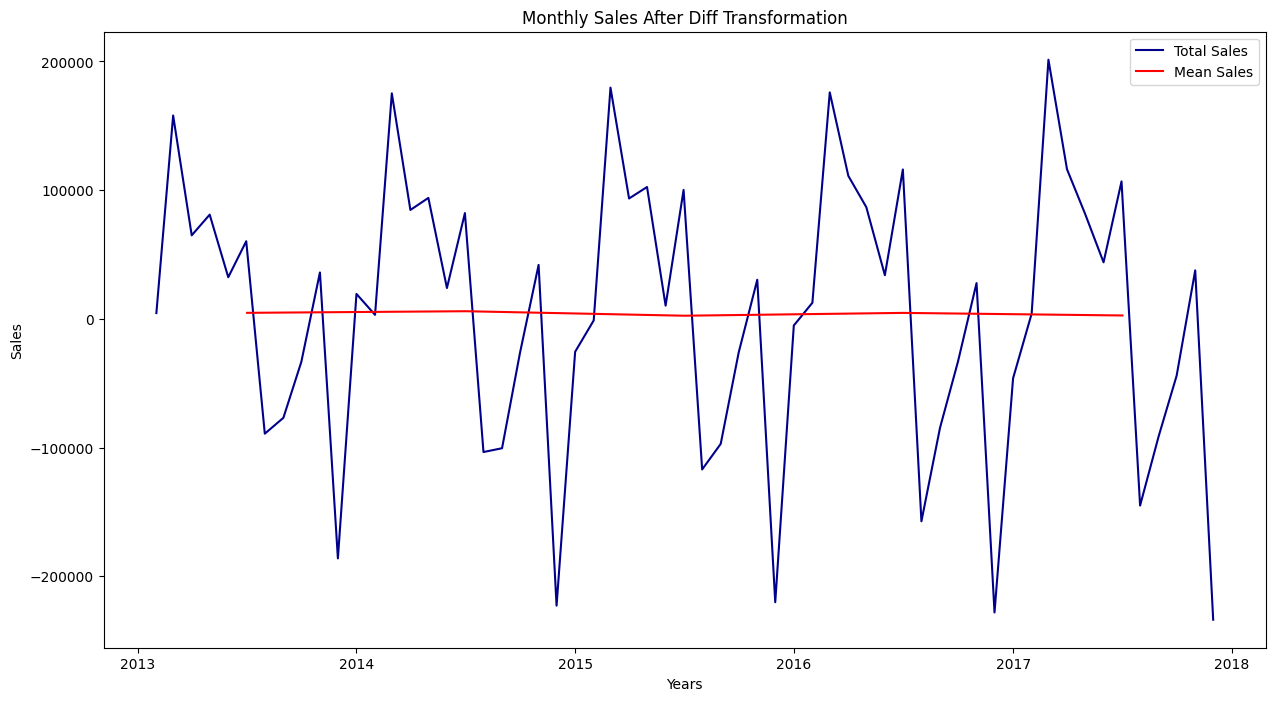

In [24]:
stationary_df = get_diff(m_df)
time_plot(stationary_df, 'date', 'sales_diff', 
          'Monthly Sales After Diff Transformation')

## Train Test Split

In [25]:
def built_supervised(data):
    supervised_df = data.copy()

    # Create column for each lag:
    for i in range(1, 13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)

    # Drop null values:
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv('./model_df.csv', index=False)
    
    return supervised_df

In [26]:
model_df = built_supervised(stationary_df)
model_df 

,date,sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,2014-07-01,989010,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,2014-08-01,885596,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,2014-09-01,785124,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,2014-10-01,758883,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,2014-11-01,800783,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [27]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        47 non-null     datetime64[ns]
 1   sales       47 non-null     int64         
 2   sales_diff  47 non-null     float64       
 3   lag_1       47 non-null     float64       
 4   lag_2       47 non-null     float64       
 5   lag_3       47 non-null     float64       
 6   lag_4       47 non-null     float64       
 7   lag_5       47 non-null     float64       
 8   lag_6       47 non-null     float64       
 9   lag_7       47 non-null     float64       
 10  lag_8       47 non-null     float64       
 11  lag_9       47 non-null     float64       
 12  lag_10      47 non-null     float64       
 13  lag_11      47 non-null     float64       
 14  lag_12      47 non-null     float64       
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 5.6 KB


In [28]:
def train_test_split(data):
    data = data.drop(['sales','date'], axis=1)
    train , test = data[:-12].values, data[-12:].values
    
    return train, test

train, test = train_test_split(model_df)
print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}")

Shape of  Train: (35, 13)
Shape of  Test: (12, 13)


## Scale The Data

In [29]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""
    
    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")


Shape of X Train: (35, 12)
Shape of y Train: (35,)
Shape of X Test: (12, 12)
Shape of y Test: (12,)


In [30]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on predictions."""
   # y_pred: model predictions
   # x_test: features from the test set used for predictions
   # scaler_obj: the scaler objects used for min-max scaling
   # lstm: indicate if the model run is the lstm. If True, additional transformation occurs 
    
    # Reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

## Predictions Dataframe

In [31]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted sales for each month
    for plotting results."""
    
    # unscale_predictions: the model predictions that do not have min-max or other scaling applied
    # origin_df: the original monthly sales dataframe
    
    # Create dataframe that shows the predicted sales:
    result_list = []
    sales_dates = list(origin_df[-13:].date)
    act_sales = list(origin_df[-13:].sales)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscale_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index + 1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

## Score The Models

In [32]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""
    
    rmse = np.sqrt(mean_squared_error(origin_df.sales[-12:], 
                                      unscale_df.pred_value[-12:]))
    
    mae = mean_absolute_error(origin_df.sales[-12:], 
                              unscale_df.pred_value[-12:])
    
    r2 = r2_score(origin_df.sales[-12:], 
                  unscale_df.pred_value[-12:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

In [33]:
def plot_results(results, origin_df, model_name):
# results: a dataframe with unscaled predictions

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x=origin_df.date, y=origin_df.sales, data=origin_df, ax=ax, 
                 label='Original', color='blue')
    sns.lineplot(x=results.date, y=results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='red')
    
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend(loc='best')
    
    filepath = Path('./model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'./model_output/{model_name}_forecasting.svg')

In [34]:
def lstm_model(train_data, test_data):
    """Runs a long-short-term-memory neural net with 2 dense layers. 
    Generates predictions that are then unscaled. 
    Scores are printed and the results are plotted and saved."""
    # train_data: dataset used to train the model
    # test_data: dataset used to test the model
   
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    
    # Build LSTM:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    model.save("mymodel")
    ip = [[[-1.02635392, 0.24535439,-0.05787474,-0.31370458,-0.67437352,
    0.68397168, 0.27578914, 0.53846345, 0.65919343, 0.98155922,
    0.16933959,0.0816042 ]]]

    print("Prediction is .....")
    print(model.predict(ip,batch_size=5))

    
    # Undo scaling to compare predictions against original data:
    origin_df = m_df
    unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = prediction_df(unscaled, origin_df)
    
    get_scores(unscaled_df, origin_df, 'LSTM')
    plot_results(unscaled_df, origin_df, 'LSTM')
    

Epoch 1/50


2023-05-09 12:55:30.197164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 12:55:30.198711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 12:55:30.199847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

35/35 [==============================] - 1s 2ms/step - loss: 0.3123 - accuracy: 0.0000e+00
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.2906 - accuracy: 0.0000e+00
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.2627 - accuracy: 0.0000e+00
Epoch 4/50
35/35 [==============================] - 0s 1ms/step - loss: 0.2418 - accuracy: 0.0000e+00
Epoch 5/50
35/35 [==============================] - 0s 1ms/step - loss: 0.2247 - accuracy: 0.0000e+00
Epoch 6/50
35/35 [==============================] - 0s 1ms/step - loss: 0.2100 - accuracy: 0.0000e+00
Epoch 7/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1966 - accuracy: 0.0000e+00
Epoch 8/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1840 - accuracy: 0.0000e+00
Epoch 9/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1717 - accuracy: 0.0000e+00
Epoch 10/50
35/35 [==============================] - 0s 1ms/step - loss: 0.1596 - accuracy: 0

2023-05-09 12:55:34.288614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 12:55:34.290240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 12:55:34.291469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: mymodel/assets


INFO:tensorflow:Assets written to: mymodel/assets


Prediction is .....
1/1 [==============================] - 0s 323ms/step


2023-05-09 12:55:38.060591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 12:55:38.062156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 12:55:38.063351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

[[0.02732637]]
RMSE: 18166.22383711045
MAE: 15134.5
R2 Score: 0.9883553538777081


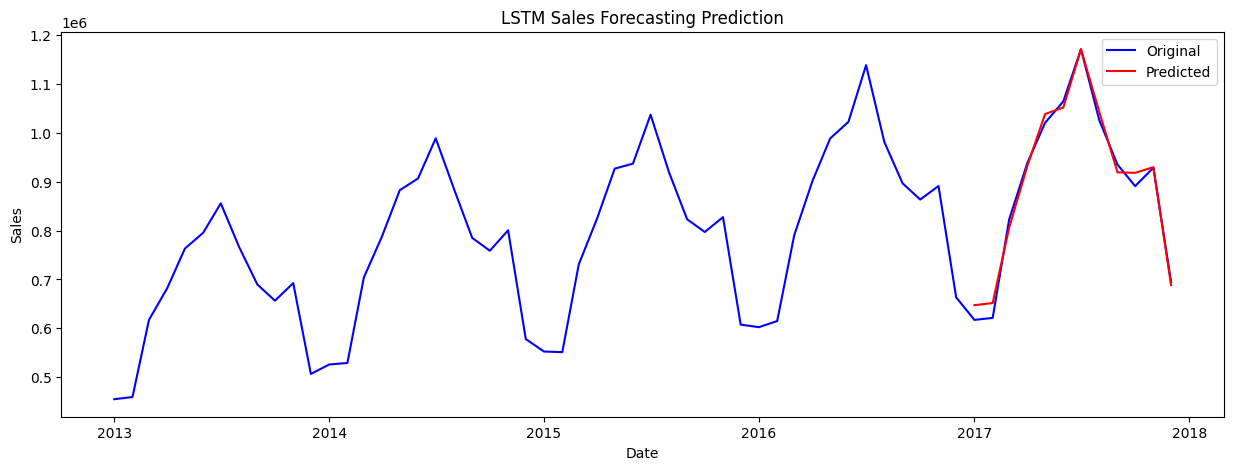

In [35]:
lstm_model(train,test)

In [37]:
import tf2onnx
import onnxruntime as rt
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = keras.models.load_model('mymodel')
spec = (tf.TensorSpec((None, 1, 12), tf.float32, name="serving_default_lstm_5_input"),)
output_path = "mymodel" + ".onnx"

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=7, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]


x = [[[-1.02635392, 0.24535439,-0.05787474,-0.31370458,-0.67437352,
    0.68397168, 0.27578914, 0.53846345, 0.65919343, 0.98155922,
    0.16933959,0.0816042 ]]]

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
onnx_pred = m.run(output_names, {"serving_default_lstm_5_input": x})

print('ONNX Predicted:', onnx_pred)
#print('ONNX Predicted:', decode_predictions(onnx_pred[0], top=3)[0])

# make sure ONNX and keras have the same results
#np.testing.assert_allclose(preds, onnx_pred[0], rtol=1e-5)

2023-05-09 12:57:26.776350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-05-09 12:57:26.776487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-05-09 12:57:26.776572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ONNX Predicted: [array([[0.0273264]], dtype=float32)]


2023-05-09 12:57:28.300567252 [W:onnxruntime:, graph.cc:1231 Graph] Initializer sequential/dense_1/MatMul/ReadVariableOp:0 appears in graph inputs and will not be treated as constant value/weight. This may prevent some of the graph optimizations, like const folding. Move it out of graph inputs if there is no need to override it, by either re-generating the model with latest exporter/converter or with the tool onnxruntime/tools/python/remove_initializer_from_input.py.
2023-05-09 12:57:28.300587559 [W:onnxruntime:, graph.cc:1231 Graph] Initializer sequential/dense_1/BiasAdd/ReadVariableOp:0 appears in graph inputs and will not be treated as constant value/weight. This may prevent some of the graph optimizations, like const folding. Move it out of graph inputs if there is no need to override it, by either re-generating the model with latest exporter/converter or with the tool onnxruntime/tools/python/remove_initializer_from_input.py.
2023-05-09 12:57:28.300593570 [W:onnxruntime:, graph.cc

In [38]:
!python -m tf2onnx.convert \
        --saved-model mymodel \
        --output ./mymodel.onnx \
        --opset 7

/usr/lib64/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-05-09 13:12:39,918 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-05-09 13:12:41,131 - INFO - Signatures found in model: [serving_default].
2023-05-09 13:12:41,131 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-05-09 13:12:41,131 - INFO - Output names: ['dense_1']
2023-05-09 13:12:41,210 - WARNING - TF freezing failed. Attempting to fix freezing errors.
2023-05-09 13:12:41,210 - WARNING - Removed Sigmoid StatefulPartitionedCall/sequential/lstm/AssignVariableOp_1
2023-05-09 13:12:41,210 - WARNING - Removed Sigmoid StatefulPartitionedCall/sequential/lstm/AssignVariableOp
2023-05-09 13:12:41,253 - INFO - Using tensorflow=2.12.0, onnx=1.14.0, tf2onnx=1.14.0/8f8d49
2023-05-09 13:12